In [114]:
import cv2
import matplotlib.pyplot as plt
import sort
from pydarknet import Detector, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [115]:
classes = None
with open('./data/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
f.close()
#classes

In [116]:
image_path ='istockphoto-1178084326-612x612.jpg' 
input_image = plt.imread(image_path)
image=input_image.copy()

In [117]:
class Object_Detector():
  """
  YOLO-v3 based object detector. This YOLO-v3 is pretrained on MS-COCO dataset.
  """
  def __init__(self,classes_path='./data/coco.names'):
    self.network = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
    #self.image_path=image_path
    with open(classes_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    f.close()
    self.classes=classes
    
  def crop_image(self,image_path):
    img = plt.imread(image_path)
    height = img.shape[0]
    width = img.shape[1]
    # Cut the image in half
    width_cutoff = width // 2
    height_cutoff=height//2
    left1 = img[height_cutoff:, :width_cutoff]
    right1 = img[:height_cutoff, width_cutoff:]
    right2 = img[:height_cutoff, :width_cutoff]
    left2 = img[height_cutoff:, width_cutoff:]
    return left1,right1,right2,left2

  def get_yolo_output(self,input_image):
        image=input_image
        self.network.setInput(cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False))
        layer_names = self.network.getLayerNames()
        output_layers = [layer_names[i - 1] for i in self.network.getUnconnectedOutLayers()]
        outs = self.network.forward(output_layers)
        class_ids = []
        confidences = []
        boxes = []
        Width = image.shape[1]
        Height = image.shape[0]
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.1:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
        kept_boxes=[]
        for i in indices:
            #i = i[0]
            box = boxes[i]
            if class_ids[i]==0:
                kept_boxes.append(box)
                label = str(self.classes[class_id]) 
                cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (0, 0, 0), 2)
                cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        return kept_boxes,image
  def detect(self,show_results=False):
    
    outputs=list(self.crop_image())
    image_datas=[]
    boxes=[]
    for element in outputs:
        kept_boxes,image=self.get_yolo_output(element)
        boxes.append(kept_boxes)
        image_datas.append(image)
    if show_results:
        f, axarr = plt.subplots(2,2)
        axarr[0,0].imshow(image_datas[0])
        axarr[0,1].imshow(image_datas[1])
        axarr[1,0].imshow(image_datas[2])
        axarr[1,1].imshow(image_datas[3])
    return list(np.concatenate(boxes))
  def extract_xy_coordinates(self,frame=1):
        
    boxes=self.detect(show_results=True)
    tracker=pd.DataFrame(columns=['Frame','x_coordinate','y_coordinate'])
    for box in boxes:
        pedestrian_x=(box[1]-box[0])/2
        pedestrian_y=(box[3]-box[2])/2
        tracker.loc[len(tracker)]=[frame,pedestrian_x,pedestrian_y]
    return tracker
  def compute_bounding_box_surfaces(self,box):
        
        return abs((box[2]-box[0]) * (box[3]-box[1]))

  def zoom_at(self,img, zoom=2, angle=0, coord=None):
        
        cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
        rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
        result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result

In [118]:
tracker=Object_Detector()

In [119]:
boxes,output=tracker.get_yolo_output(input_image)

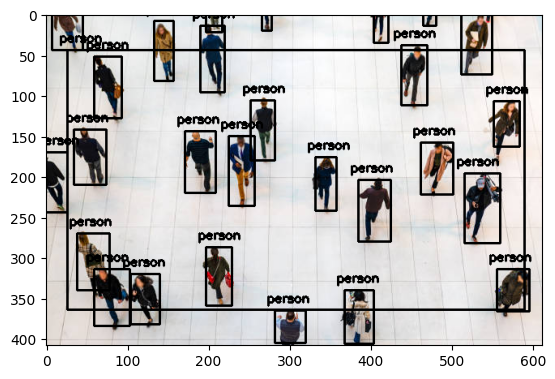

In [123]:
plt.imshow(output)

In [309]:
extract_xy_coordinates(boxes,frame=1)

,Frame,x_coordinate,y_coordinate
0,1.0,2.75,56.5
1,1.0,178.50,-11.0
2,1.0,-29.50,33.0
3,1.0,6.25,65.5
4,1.0,259.25,-4.5
...,...,...,...
119,1.0,-362.00,18.0
120,1.0,154.50,58.0
121,1.0,-309.75,10.5
122,1.0,-232.25,8.5
